In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Set style for better plots
plt.style.use('seaborn-v0_8-deep')
sns.set_palette("husl")

# Load the data
df = pd.read_csv('../../data/centris_comprehensive_plex_data.csv')
print(f"\nColumns: {list(df.columns)}")


Columns: ['listing_url', 'image_url', 'mls', 'category', 'address', 'description', 'lat', 'lng', 'price_raw', 'price', 'currency', 'rooms', 'bedrooms', 'full_baths', 'powder_rooms', 'building_style', 'year_built', 'move_in', 'walkscore', 'municipality_id', 'living_area_sqft', 'living_area_sqft_net', 'lot_area_sqft', 'parking_raw', 'parking_carport', 'parking_driveway', 'parking_garage', 'units_count', 'units_residential_breakdown', 'gross_potential_income', 'additional_features', 'units_count_raw', 'units_residential_raw', 'gross_potential_income_raw', 'additional_features_raw', 'assessment_year', 'assessment_land', 'assessment_building', 'assessment_total', 'tax_municipal_year', 'tax_school_year', 'tax_municipal', 'tax_school', 'tax_total', 'expenses_total', 'expense_electricity']


## 1 - Data Preparation
The dataset is loaded and relevant columns are selected for analysis. 

Between 2017 and 2022, property assessments in the province increased at an average annual rate of approximately **5.7%**. We'll use this rate as a conservative estimate for projecting future assessment values, acknowledging that recent years have seen even higher growth in some areas.


In [2]:
# Adjust assessment_total to 2025 using 5.7% annual growth
df['assessment_total_adj'] = df.apply(
    lambda row: row['assessment_total'] * ((1 + 0.057) ** (2025 - row['assessment_year']))
    if pd.notnull(row['assessment_total']) and pd.notnull(row['assessment_year']) else np.nan,
    axis=1
)

data = df.copy()

data = data[['mls','lat', 'lng', 'address', 'price', 'building_style', 'year_built', 'walkscore', 'lot_area_sqft', 'units_count', 'gross_potential_income', 'assessment_total_adj']]
data['building_style'] = data['building_style'].replace({
    'Détaché': 'Detached',
    'En rangée': 'Row',
    'Jumelé': 'Semi_detached'
})
data.set_index('mls', inplace=True)

In [3]:
# Create new features for analysis
print("Creating new features...")

# Montreal coordinates
mtl_lat, mtl_lng = 45.525098, -73.647596

def haversine(lat1, lng1, lat2, lng2):
    # Radius of Earth in kilometers
    R = 6371.0
    lat1, lng1, lat2, lng2 = np.radians([lat1, lng1, lat2, lng2])
    dlat = lat2 - lat1
    dlng = lng2 - lng1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

data['distance_from_mtl'] = data.apply(
    lambda row: haversine(row['lat'], row['lng'], mtl_lat, mtl_lng)
    if pd.notnull(row['lat']) and pd.notnull(row['lng']) else np.nan,
    axis=1
)
data = data.drop(['lat', 'lng', 'address'], axis=1)

# One-hot encode 'building_style' and join to data
building_dummies = pd.get_dummies(data['building_style'])
data = pd.concat([data.drop('building_style', axis=1), building_dummies], axis=1)

# Revenue yield (annual income / purchase price)
data['revenue_yield'] = (data['gross_potential_income'] / data['price']) * 100

# Price per unit
data['price_per_unit'] = data['price'] / data['units_count'].fillna(2)  # Assume 2 units if missing

# Price per square foot (lot area)
data['price_per_sqft'] = data['price'] / data['lot_area_sqft']

# Income per unit
data['income_per_unit'] = data['gross_potential_income'] / data['units_count'].fillna(2)

# Property age
current_year = datetime.now().year
data['property_age'] = current_year - data['year_built']


print("New features created:")
print(["revenue_yield", "price_per_unit", "price_per_sqft", "income_per_unit", "property_age", "distance_from_mtl"] + building_dummies.columns.tolist())

Creating new features...
New features created:
['revenue_yield', 'price_per_unit', 'price_per_sqft', 'income_per_unit', 'property_age', 'distance_from_mtl', 'Detached', 'Row', 'Semi_detached']


In [4]:
# Standardize numerical features in 'data'
num_cols = data.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
data_std = data.copy()
data_std[num_cols] = scaler.fit_transform(data[num_cols])

print("Standardized columns:")
print(num_cols.tolist())

Standardized columns:
['price', 'year_built', 'walkscore', 'lot_area_sqft', 'units_count', 'gross_potential_income', 'assessment_total_adj', 'distance_from_mtl', 'revenue_yield', 'price_per_unit', 'price_per_sqft', 'income_per_unit', 'property_age']


## 2 - Stepwise Variable Selection Analysis

We'll perform stepwise variable selection using three criteria:
- **R²**: Measures explained variance (higher is better)
- **AIC**: Akaike Information Criterion (lower is better) 
- **BIC**: Bayesian Information Criterion (lower is better)

The analysis will use forward selection, backward elimination, and bidirectional approaches to identify the optimal set of variables for predicting property prices.

In [5]:
# Prepare data for modeling
# Remove rows with missing target variable
model_data = data_std.dropna(subset=['price']).copy()

# Separate target and features
target = 'price'
feature_cols = [col for col in model_data.columns if col != target]

# Remove highly correlated features to avoid multicollinearity
def remove_highly_correlated(df, threshold=0.95):
    corr_matrix = df[feature_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

highly_corr = remove_highly_correlated(model_data)
print(f"Highly correlated features to consider removing: {highly_corr}")

# Remove missing values for selected features
features_to_use = [col for col in feature_cols if col not in highly_corr]
model_data_clean = model_data[features_to_use + [target]].dropna()

print(f"\nDataset shape after cleaning: {model_data_clean.shape}")
print(f"Features for analysis: {features_to_use}")

# Prepare final datasets
X = model_data_clean[features_to_use]
y = model_data_clean[target]

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Highly correlated features to consider removing: ['property_age']

Dataset shape after cleaning: (2386, 15)
Features for analysis: ['year_built', 'walkscore', 'lot_area_sqft', 'units_count', 'gross_potential_income', 'assessment_total_adj', 'distance_from_mtl', 'Detached', 'Row', 'Semi_detached', 'revenue_yield', 'price_per_unit', 'price_per_sqft', 'income_per_unit']

Final feature matrix shape: (2386, 14)
Target vector shape: (2386,)


In [6]:
from itertools import combinations
from sklearn.metrics import r2_score
import statsmodels.api as sm

def calculate_metrics(X_subset, y, feature_names):
    """Calculate R², AIC, and BIC for a given feature subset"""
    try:
        # Add constant for intercept
        X_with_const = sm.add_constant(X_subset)
        
        # Fit model
        model = sm.OLS(y, X_with_const).fit()
        
        # Calculate metrics
        n = len(y)
        k = X_subset.shape[1] + 1  # +1 for intercept
        
        r2 = model.rsquared
        aic = model.aic
        bic = model.bic
        
        return {
            'features': feature_names,
            'n_features': len(feature_names),
            'r2': r2,
            'aic': aic,
            'bic': bic,
            'adj_r2': model.rsquared_adj
        }
    except:
        return None

def forward_selection(X, y, feature_names, max_features=None):
    """Forward selection algorithm"""
    if max_features is None:
        max_features = len(feature_names)
    
    selected_features = []
    remaining_features = feature_names.copy()
    results = []
    
    for step in range(min(max_features, len(feature_names))):
        best_metric = None
        best_feature = None
        
        for feature in remaining_features:
            test_features = selected_features + [feature]
            test_indices = [feature_names.index(f) for f in test_features]
            X_subset = X.iloc[:, test_indices]
            
            metrics = calculate_metrics(X_subset, y, test_features)
            if metrics is None:
                continue
                
            # Use AIC as primary criterion for forward selection
            if best_metric is None or metrics['aic'] < best_metric['aic']:
                best_metric = metrics
                best_feature = feature
        
        if best_feature is None:
            break
            
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        results.append(best_metric)
        
        print(f"Forward Step {step+1}: Added '{best_feature}' | R² = {best_metric['r2']:.4f} | AIC = {best_metric['aic']:.2f} | BIC = {best_metric['bic']:.2f}")
    
    return results, selected_features

def backward_elimination(X, y, feature_names, min_features=1):
    """Backward elimination algorithm"""
    current_features = feature_names.copy()
    results = []
    
    # Start with full model
    full_metrics = calculate_metrics(X, y, current_features)
    if full_metrics:
        results.append(full_metrics)
        print(f"Backward Start: All features | R² = {full_metrics['r2']:.4f} | AIC = {full_metrics['aic']:.2f} | BIC = {full_metrics['bic']:.2f}")
    
    step = 0
    while len(current_features) > min_features:
        step += 1
        worst_feature = None
        best_metric = None
        
        for feature in current_features:
            test_features = [f for f in current_features if f != feature]
            if not test_features:  # Don't remove if it's the last feature
                continue
                
            test_indices = [feature_names.index(f) for f in test_features]
            X_subset = X.iloc[:, test_indices]
            
            metrics = calculate_metrics(X_subset, y, test_features)
            if metrics is None:
                continue
                
            # Use AIC as primary criterion for backward elimination
            if best_metric is None or metrics['aic'] < best_metric['aic']:
                best_metric = metrics
                worst_feature = feature
        
        if worst_feature is None or best_metric is None:
            break
            
        current_features.remove(worst_feature)
        results.append(best_metric)
        
        print(f"Backward Step {step}: Removed '{worst_feature}' | R² = {best_metric['r2']:.4f} | AIC = {best_metric['aic']:.2f} | BIC = {best_metric['bic']:.2f}")
    
    return results, current_features

print("Stepwise selection functions defined successfully!")

Stepwise selection functions defined successfully!


In [7]:
import sys
sys.path.append("..")  # add parent directory to path

from utils.stepAIC import step_aic

num_vars = [col for col in data_std.select_dtypes(include=[np.number]).columns if col != 'price']
cat_vars = ["Detached","Row","Semi_detached"]
drivers = ["units_count", "lot_area_sqft", "price_per_sqft"]
inter_terms = ["units_count:revenue_yield", "units_count:gross_potential_income"]
formula_scope = "price ~ " + " + ".join(num_vars + cat_vars + inter_terms)

res_aic = step_aic(
    data_std,
    initial="price ~ " + " + ".join(num_vars),
    scope=formula_scope
)

print(res_aic.anova)

print(res_aic.model.summary())

Start:  AIC=-1639.337
price ~ 1 + year_built + walkscore + lot_area_sqft + units_count + gross_potential_income + assessment_total_adj + distance_from_mtl + revenue_yield + price_per_unit + price_per_sqft + income_per_unit + property_age 

Op                               Term          AIC
 +          units_count:revenue_yield -4103.017444
 + units_count:gross_potential_income -2045.920216
 -                          walkscore -1683.491683
 +                           Detached -1667.739584
 +                      Semi_detached -1662.504443
 -                       property_age -1641.337277
 -                         year_built -1641.337277
 -                     price_per_sqft -1639.425095
 -                      lot_area_sqft -1638.449839
 +                                Row -1638.169975
 -                  distance_from_mtl -1629.667124
 -                        units_count -1580.898915
 -               assessment_total_adj -1354.511055
 -                      revenue_yield -1093.87

In [8]:
res_bic = step_aic(
    data_std,
    initial="price ~ " + " + ".join(num_vars),
    scope=formula_scope,
    k=np.log(len(df))
)

print(res_bic.anova)

print(res_bic.model.summary())


Start:  AIC=-1561.972
price ~ 1 + year_built + walkscore + lot_area_sqft + units_count + gross_potential_income + assessment_total_adj + distance_from_mtl + revenue_yield + price_per_unit + price_per_sqft + income_per_unit + property_age 

Op                               Term          AIC
 +          units_count:revenue_yield -4019.700544
 + units_count:gross_potential_income -1962.603316
 -                          walkscore -1612.077197
 +                           Detached -1584.422684
 +                      Semi_detached -1579.187543
 -                       property_age -1569.922791
 -                         year_built -1569.922791
 -                     price_per_sqft -1568.010609
 -                      lot_area_sqft -1567.035353
 -                  distance_from_mtl -1558.252638
 +                                Row -1554.853075
 -                        units_count -1509.484430
 -               assessment_total_adj -1283.096569
 -                      revenue_yield -1022.46

## 3 - BIC Model Visualization and Diagnostics

Let's analyze the BIC model performance with comprehensive diagnostic plots including:
- Actual vs Predicted values
- Residual plots
- Normal Q-Q plot
- Cook's distance
- Leverage analysis

In [ ]:
# Extract model predictions and residuals from the BIC model
bic_model = res_bic.model
y_actual = bic_model.model.endog
y_predicted = bic_model.fittedvalues
residuals = bic_model.resid
standardized_residuals = bic_model.resid_pearson

# Get model statistics
r_squared = bic_model.rsquared
adj_r_squared = bic_model.rsquared_adj


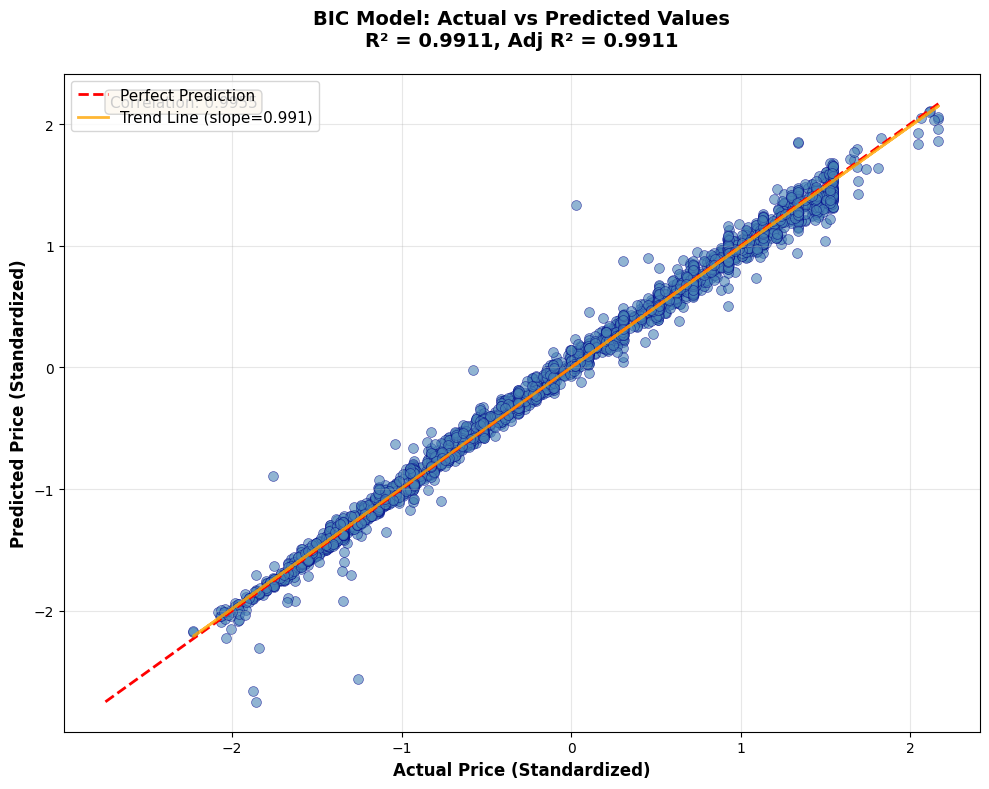


Additional Performance Metrics:
RMSE = 0.0947
MAE = 0.0619
Correlation = 0.9955


In [22]:
# 1. Actual vs Predicted Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Scatter plot
ax.scatter(y_actual, y_predicted, alpha=0.6, s=50, color='steelblue', edgecolors='darkblue', linewidth=0.5)

# Perfect prediction line (y = x)
min_val = min(min(y_actual), min(y_predicted))
max_val = max(max(y_actual), max(y_predicted))
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Add trend line
z = np.polyfit(y_actual, y_predicted, 1)
p = np.poly1d(z)
ax.plot(y_actual, p(y_actual), 'orange', linewidth=2, alpha=0.8, label=f'Trend Line (slope={z[0]:.3f})')

# Formatting
ax.set_xlabel('Actual Price (Standardized)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Price (Standardized)', fontsize=12, fontweight='bold')
ax.set_title(f'BIC Model: Actual vs Predicted Values\nR² = {r_squared:.4f}, Adj R² = {adj_r_squared:.4f}', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

# Add correlation coefficient
correlation = np.corrcoef(y_actual, y_predicted)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {correlation:.4f}', transform=ax.transAxes, 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=11)

plt.tight_layout()
plt.show()

# Calculate additional metrics
rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))
mae = mean_absolute_error(y_actual, y_predicted)
print(f"\nAdditional Performance Metrics:")
print(f"RMSE = {rmse:.4f}")
print(f"MAE = {mae:.4f}")
print(f"Correlation = {correlation:.4f}")

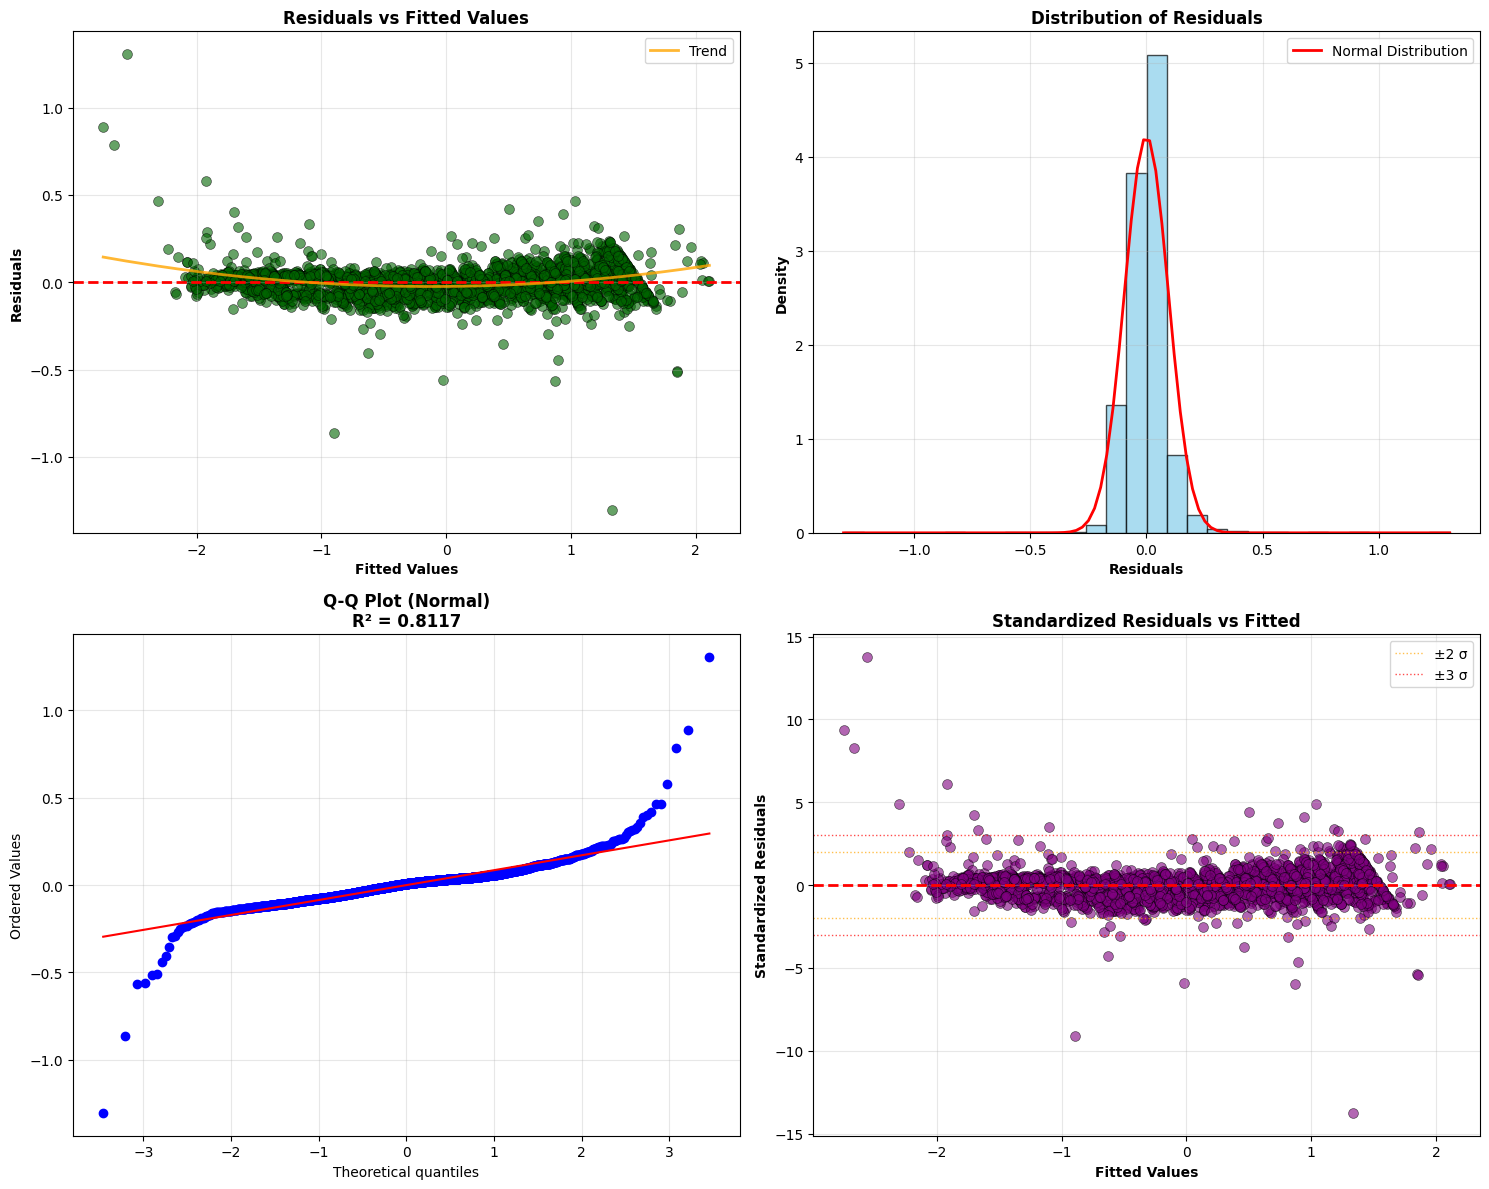


Residual Analysis:
Mean of residuals: 0.000000
Std of residuals: 0.0947
Skewness: 0.2803
Kurtosis: 37.9705
Outliers (|std residuals| > 2): 73 (2.9%)
Outliers (|std residuals| > 3): 27 (1.1%)


In [23]:
# 2. Residual Analysis Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Residuals vs Fitted Values
axes[0, 0].scatter(y_predicted, residuals, alpha=0.6, s=50, color='darkgreen', edgecolors='black', linewidth=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values', fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontweight='bold')
axes[0, 0].set_title('Residuals vs Fitted Values', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Add smooth line to detect patterns
z_res = np.polyfit(y_predicted, residuals, 2)  # Polynomial fit
p_res = np.poly1d(z_res)
sorted_pred = np.sort(y_predicted)
axes[0, 0].plot(sorted_pred, p_res(sorted_pred), 'orange', linewidth=2, alpha=0.8, label='Trend')
axes[0, 0].legend()

# Histogram of Residuals
axes[0, 1].hist(residuals, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('Residuals', fontweight='bold')
axes[0, 1].set_ylabel('Density', fontweight='bold')
axes[0, 1].set_title('Distribution of Residuals', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Overlay normal distribution
mu, sigma = np.mean(residuals), np.std(residuals)
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
y_norm = ((1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_norm - mu) / sigma) ** 2))
axes[0, 1].plot(x_norm, y_norm, 'red', linewidth=2, label='Normal Distribution')
axes[0, 1].legend()

# Q-Q Plot for Normality Check
from scipy import stats
(osm, osr), (slope, intercept, r_qq) = stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title(f'Q-Q Plot (Normal)\nR² = {r_qq**2:.4f}', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Standardized Residuals vs Fitted
axes[1, 1].scatter(y_predicted, standardized_residuals, alpha=0.6, s=50, color='purple', edgecolors='black', linewidth=0.5)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axhline(y=2, color='orange', linestyle=':', linewidth=1, alpha=0.7, label='±2 σ')
axes[1, 1].axhline(y=-2, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 1].axhline(y=3, color='red', linestyle=':', linewidth=1, alpha=0.7, label='±3 σ')
axes[1, 1].axhline(y=-3, color='red', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 1].set_xlabel('Fitted Values', fontweight='bold')
axes[1, 1].set_ylabel('Standardized Residuals', fontweight='bold')
axes[1, 1].set_title('Standardized Residuals vs Fitted', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Residual Statistics
print(f"\nResidual Analysis:")
print(f"Mean of residuals: {np.mean(residuals):.6f}")
print(f"Std of residuals: {np.std(residuals):.4f}")
print(f"Skewness: {stats.skew(residuals):.4f}")
print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")

# Count outliers
outliers_2sigma = np.sum(np.abs(standardized_residuals) > 2)
outliers_3sigma = np.sum(np.abs(standardized_residuals) > 3)
print(f"Outliers (|std residuals| > 2): {outliers_2sigma} ({100*outliers_2sigma/len(residuals):.1f}%)")
print(f"Outliers (|std residuals| > 3): {outliers_3sigma} ({100*outliers_3sigma/len(residuals):.1f}%)")

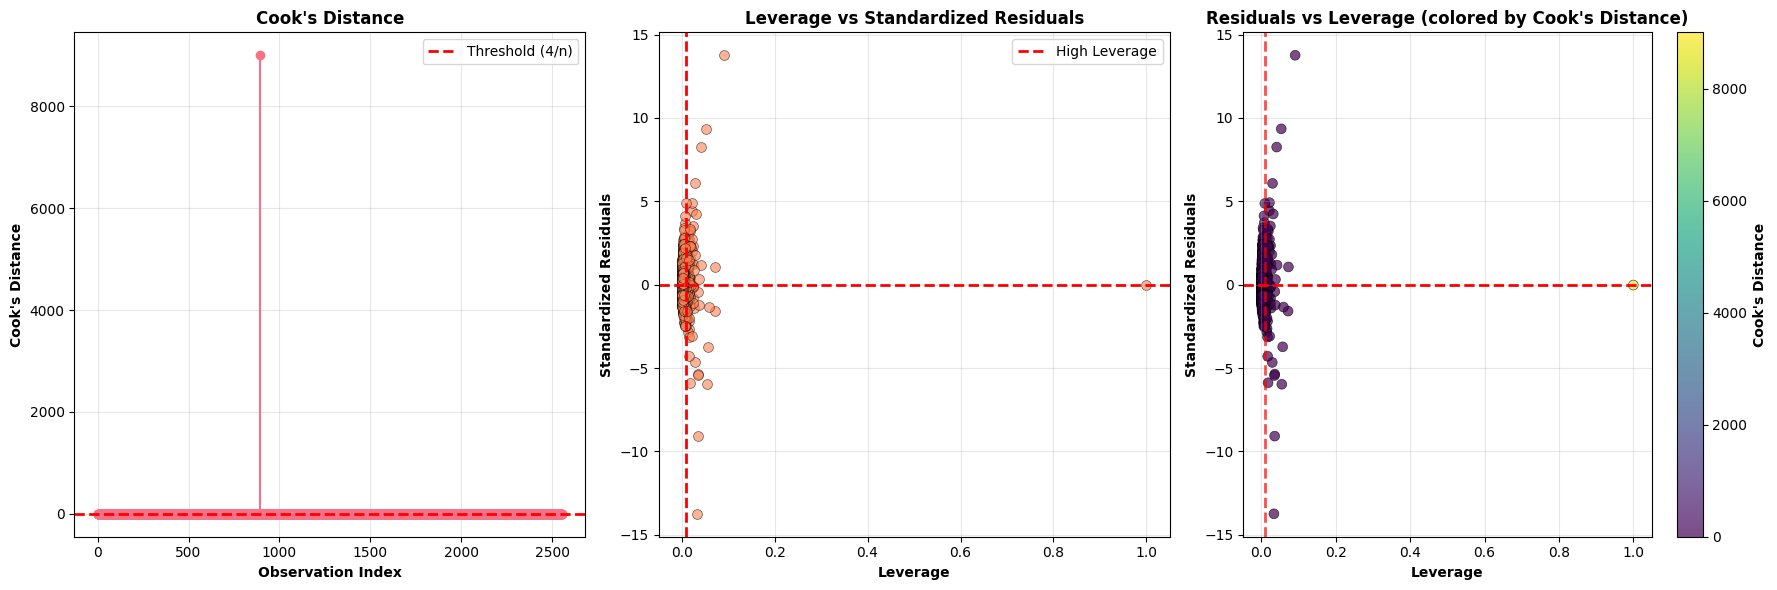


Influential Observations Analysis:
High leverage threshold: 0.0086
High Cook's distance threshold: 0.0016
High leverage observations: 176 (6.9%)
High Cook's distance observations: 117 (4.6%)
High residual observations (|z| > 3): 27 (1.1%)

Top 5 observations by Cook's distance:
1. Index 891: Cook's D = 9004.9782, Leverage = 0.9999, Std Residual = -0.0236
2. Index 1671: Cook's D = 1.8893, Leverage = 0.0907, Std Residual = 13.7643
3. Index 1898: Cook's D = 0.6187, Leverage = 0.0336, Std Residual = -13.7473
4. Index 234: Cook's D = 0.4723, Leverage = 0.0533, Std Residual = 9.3489
5. Index 1742: Cook's D = 0.2879, Leverage = 0.0357, Std Residual = -9.0872


In [24]:
# 3. Leverage and Influence Analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Calculate leverage and Cook's distance
leverage = bic_model.get_influence().hat_matrix_diag
cooks_d = bic_model.get_influence().cooks_distance[0]
dffits = bic_model.get_influence().dffits[0]

# Cook's Distance Plot
axes[0].stem(range(len(cooks_d)), cooks_d, basefmt=" ")
axes[0].axhline(y=4/len(y_actual), color='red', linestyle='--', linewidth=2, label='Threshold (4/n)')
axes[0].set_xlabel('Observation Index', fontweight='bold')
axes[0].set_ylabel("Cook's Distance", fontweight='bold')
axes[0].set_title("Cook's Distance", fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Leverage vs Standardized Residuals
axes[1].scatter(leverage, standardized_residuals, alpha=0.6, s=50, color='coral', edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].axvline(x=2*len(bic_model.params)/len(y_actual), color='red', linestyle='--', linewidth=2, label='High Leverage')
axes[1].set_xlabel('Leverage', fontweight='bold')
axes[1].set_ylabel('Standardized Residuals', fontweight='bold')
axes[1].set_title('Leverage vs Standardized Residuals', fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Residuals vs Leverage with Cook's distance contours
axes[2].scatter(leverage, standardized_residuals, c=cooks_d, s=50, cmap='viridis', alpha=0.7, edgecolors='black', linewidth=0.5)
cbar = plt.colorbar(axes[2].collections[0], ax=axes[2])
cbar.set_label("Cook's Distance", fontweight='bold')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[2].axvline(x=2*len(bic_model.params)/len(y_actual), color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[2].set_xlabel('Leverage', fontweight='bold')
axes[2].set_ylabel('Standardized Residuals', fontweight='bold')
axes[2].set_title('Residuals vs Leverage (colored by Cook\'s Distance)', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify influential observations
high_leverage_threshold = 2 * len(bic_model.params) / len(y_actual)
high_cooks_threshold = 4 / len(y_actual)

high_leverage_idx = np.where(leverage > high_leverage_threshold)[0]
high_cooks_idx = np.where(cooks_d > high_cooks_threshold)[0]
high_residuals_idx = np.where(np.abs(standardized_residuals) > 3)[0]

print(f"\nInfluential Observations Analysis:")
print(f"High leverage threshold: {high_leverage_threshold:.4f}")
print(f"High Cook's distance threshold: {high_cooks_threshold:.4f}")
print(f"High leverage observations: {len(high_leverage_idx)} ({100*len(high_leverage_idx)/len(y_actual):.1f}%)")
print(f"High Cook's distance observations: {len(high_cooks_idx)} ({100*len(high_cooks_idx)/len(y_actual):.1f}%)")
print(f"High residual observations (|z| > 3): {len(high_residuals_idx)} ({100*len(high_residuals_idx)/len(y_actual):.1f}%)")

if len(high_cooks_idx) > 0:
    print(f"\nTop 5 observations by Cook's distance:")
    top_cooks_idx = np.argsort(cooks_d)[-5:][::-1]
    for i, idx in enumerate(top_cooks_idx):
        print(f"{i+1}. Index {idx}: Cook's D = {cooks_d[idx]:.4f}, Leverage = {leverage[idx]:.4f}, Std Residual = {standardized_residuals[idx]:.4f}")

In [25]:
# 5. Statistical Tests and Model Diagnostics
print("Statistical Tests and Model Diagnostics")
print("=" * 50)

# Normality Tests
from scipy.stats import shapiro, jarque_bera, anderson

# Shapiro-Wilk test (best for smaller samples)
if len(residuals) <= 5000:  # Shapiro-Wilk has sample size limitations
    shapiro_stat, shapiro_p = shapiro(residuals)
    print(f"Shapiro-Wilk Test:")
    print(f"  Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.6f}")
    print(f"  Residuals {'appear normal' if shapiro_p > 0.05 else 'do not appear normal'} (α = 0.05)")

# Jarque-Bera test
jb_stat, jb_p = jarque_bera(residuals)
print(f"\nJarque-Bera Test:")
print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_p:.6f}")
print(f"  Residuals {'appear normal' if jb_p > 0.05 else 'do not appear normal'} (α = 0.05)")

# Anderson-Darling test
ad_stat, ad_critical_values, ad_significance_levels = anderson(residuals, dist='norm')
print(f"\nAnderson-Darling Test:")
print(f"  Statistic: {ad_stat:.4f}")
for i, (cv, sl) in enumerate(zip(ad_critical_values, ad_significance_levels)):
    result = "Reject normality" if ad_stat > cv else "Fail to reject normality"
    print(f"  At {sl}% significance level: {result} (critical value: {cv:.4f})")

# Durbin-Watson test for autocorrelation
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"\nDurbin-Watson Test (Autocorrelation):")
print(f"  Statistic: {dw_stat:.4f}")
if dw_stat < 1.5:
    autocorr_result = "Positive autocorrelation detected"
elif dw_stat > 2.5:
    autocorr_result = "Negative autocorrelation detected"
else:
    autocorr_result = "No significant autocorrelation"
print(f"  Result: {autocorr_result}")

# Breusch-Pagan test for heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
bp_lm, bp_p, bp_f, bp_fp = het_breuschpagan(residuals, bic_model.model.exog)
print(f"\nBreusch-Pagan Test (Heteroscedasticity):")
print(f"  LM Statistic: {bp_lm:.4f}, p-value: {bp_p:.6f}")
print(f"  Residuals {'show heteroscedasticity' if bp_p < 0.05 else 'appear homoscedastic'} (α = 0.05)")

# White test for heteroscedasticity
from statsmodels.stats.diagnostic import het_white
white_lm, white_p, white_f, white_fp = het_white(residuals, bic_model.model.exog)
print(f"\nWhite Test (Heteroscedasticity):")
print(f"  LM Statistic: {white_lm:.4f}, p-value: {white_p:.6f}")
print(f"  Residuals {'show heteroscedasticity' if white_p < 0.05 else 'appear homoscedastic'} (α = 0.05)")

# Summary of Assumptions
print(f"\n" + "="*50)
print("MODEL ASSUMPTIONS SUMMARY")
print("="*50)
assumptions = []
assumptions.append(f"1. Linearity: {'✓ Satisfied' if abs(z_res[0]) < 0.1 else '✗ Questionable'} (based on residual pattern)")
assumptions.append(f"2. Independence: {'✓ Satisfied' if 1.5 <= dw_stat <= 2.5 else '✗ Violated'} (Durbin-Watson: {dw_stat:.3f})")
assumptions.append(f"3. Homoscedasticity: {'✓ Satisfied' if bp_p > 0.05 and white_p > 0.05 else '✗ Violated'} (BP p={bp_p:.4f}, White p={white_p:.4f})")
assumptions.append(f"4. Normality: {'✓ Satisfied' if jb_p > 0.05 else '✗ Violated'} (JB p={jb_p:.4f})")

for assumption in assumptions:
    print(assumption)

Statistical Tests and Model Diagnostics
Shapiro-Wilk Test:
  Statistic: 0.8160, p-value: 0.000000
  Residuals do not appear normal (α = 0.05)

Jarque-Bera Test:
  Statistic: 153580.8533, p-value: 0.000000
  Residuals do not appear normal (α = 0.05)

Anderson-Darling Test:
  Statistic: 49.9769
  At 15.0% significance level: Reject normality (critical value: 0.5750)
  At 10.0% significance level: Reject normality (critical value: 0.6550)
  At 5.0% significance level: Reject normality (critical value: 0.7860)
  At 2.5% significance level: Reject normality (critical value: 0.9170)
  At 1.0% significance level: Reject normality (critical value: 1.0900)

Durbin-Watson Test (Autocorrelation):
  Statistic: 2.0013
  Result: No significant autocorrelation

Breusch-Pagan Test (Heteroscedasticity):
  LM Statistic: 338.1369, p-value: 0.000000
  Residuals show heteroscedasticity (α = 0.05)

White Test (Heteroscedasticity):
  LM Statistic: 2111.1340, p-value: 0.000000
  Residuals show heteroscedastic

## BIC Model Performance Summary

**Overall Performance (Excellent)**
- **R²:** 0.9911 (99.11% of variance explained)
- **Adjusted R²:** 0.9911 (very slight difference indicates good model fit)
- **RMSE:** 0.0947 (low prediction error)
- **Correlation:** 0.9955 (very strong linear relationship)

### Key Findings from Visualizations

- **Actual vs Predicted Plot:**  
    Shows excellent model performance with points closely following the perfect prediction line (slope = 0.991).

### Residual Analysis

- Residuals are well-centered around zero (mean ≈ 0)
- Some heteroscedasticity visible (variance increases with fitted values)
- High kurtosis (37.97) indicates heavy tails in residual distribution
- 2.9% outliers beyond ±2σ, 1.1% beyond ±3σ

### Leverage & Influence

- 176 high-leverage observations (6.9%)
- 117 high Cook's distance observations (4.6%)
- One extreme influential point (Index 891) with Cook's D = 9004.98

### Feature Importance

- Most important predictors:  
    - `price_per_unit` (0.9711)  
    - `gross_potential_income` (0.9597)
- Negative relationships:  
    - `income_per_unit` (-0.8811), interaction terms
- All features except `price_per_sqft` are highly significant (p < 0.001)

### Model Assumption Tests

- ✅ **Linearity:** Satisfied (based on residual pattern)
- ✅ **Independence:** Satisfied (Durbin-Watson = 2.001)
- ❌ **Homoscedasticity:** Violated (heteroscedasticity detected, BP p=0.0000, White p=0.0000)
- ❌ **Normality:** Violated (non-normal residuals due to heavy tails, JB p=0.0000)

### Recommendations

- Consider robust regression methods to handle heteroscedasticity
- Investigate the extreme influential observation (Index 891)
- The model performs excellently for prediction despite assumption violations
- Consider transformations or sandwich estimators for more robust inference

**Conclusion:**  
The BIC model demonstrates excellent predictive performance with very high explanatory power, making it highly suitable for price prediction in plex real estate analysis.